In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import image
#import PIL
from data_load import load_data
import random

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, MaxUnpool2d, Dropout2d, ConvTranspose2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from torchsummary import summary
import torch.optim as optim
#from torch.utils.tensorboard import SummaryWriter
#import elasticdeform
#import scipy
#from imgaug import augmenters as iaa
use_cuda = True
from sklearn.metrics import f1_score

In [ ]:
# Check if GPU is available

torch.cuda.is_available()

# Data Prep

In [2]:
X, y, X_aug, y_aug = load_data("ShowMe training data 18.8.2018", data_aug=True)


In [3]:
# Shuffle Data
random_idx = np.arange(X.shape[0])
np.random.shuffle(random_idx)

# shuffles data by using random indexes on them. Important that X and y are shuffled with same indexes
X = X[random_idx]
y = y[random_idx]
X_aug = X_aug[random_idx]
y_aug = y_aug[random_idx]

In [4]:
# Split train-test
splitlen = int(X.shape[0] * 0.8)

X_train, y_train = X[:splitlen], y[:splitlen]
X_test, y_test = X[splitlen:], y[splitlen:]
X_train_aug, y_train_aug = X_aug[:splitlen], y_aug[:splitlen]
X_aug_ignore, y_aug_ignore = X_aug[splitlen:], y_aug[splitlen:]

X_train_all = np.concatenate((X_train, X_train_aug))
y_train_all = np.concatenate((y_train, y_train_aug))

In [5]:
# Shuffle again
random_idx2 = np.arange(X_train_all.shape[0])
np.random.shuffle(random_idx2)

X_train_all = X_train_all[random_idx2]
y_train_all = y_train_all[random_idx2]

In [6]:
# Normalize data
X_train_norm = X_train/255
X_test_norm = X_test/255

X_train_all_norm = X_train_all/255

In [ ]:
for i in range(10):
    printing_example = np.reshape(X[i], [X[i].shape[1], X[i].shape[2], X[i].shape[0]])
    printing_example_aug = np.reshape(X_aug[i], [X_aug[i].shape[1], X_aug[i].shape[2], X_aug[i].shape[0]])

    #print("Input data shape:", X.shape)
    #print("Target data shape:", y.shape)
    #print("X_aug shape:", X_aug.shape)
    plt.imshow(printing_example.astype('uint8'))
    plt.show()
    #plt.imshow(y[i])
    #plt.show()
    print("Augmented Data:")
    plt.imshow(printing_example_aug.astype('uint8'))
    plt.show()
    plt.imshow(y_aug[i].astype('uint8'))
    plt.show()

# Model Implementation

In [7]:
class Unet(nn.Module):
    def __init__(self, num_channels, input_height, input_width, num_classes):
        super(Unet, self).__init__()
        self.input_height = input_height
        self.input_width = input_width
        self.downsample_factor = 2**4 # divide by 2, 4 times
        self.k = 3
        self.kernel_size  = (self.k, self.k)
        self.conv_pad = (self.k//2, self.k//2)
        
        # Encoder - downsampling the image
        self.conv1 = Conv2d(num_channels, 32, self.kernel_size, padding=self.conv_pad)
        self.conv12 = Conv2d(32, 32, self.kernel_size, padding=self.conv_pad)
        self.maxp1 = MaxPool2d((2,2))
        self.bn1 = BatchNorm2d(32)
        self.dropout = Dropout2d(p=0.2)
        
        self.conv2 = Conv2d(32, 64, self.kernel_size, padding=self.conv_pad)
        self.conv22 = Conv2d(64, 64, self.kernel_size, padding=self.conv_pad)
        self.maxp2 = MaxPool2d((2,2))
        self.bn2 = BatchNorm2d(64)
        
        self.conv3 = Conv2d(64, 128, self.kernel_size, padding=self.conv_pad)
        self.conv32 = Conv2d(128, 128, self.kernel_size, padding=self.conv_pad)
        self.maxp3 = MaxPool2d((2,2))
        self.bn3 = BatchNorm2d(128)
        
        self.conv4 = Conv2d(128, 256, self.kernel_size, padding=self.conv_pad)
        self.conv42 = Conv2d(256, 256, self.kernel_size, padding=self.conv_pad)
        self.maxp4 = MaxPool2d((2,2))
        self.bn4 = BatchNorm2d(256)
        
        self.conv5 = Conv2d(256, 512, self.kernel_size, padding=self.conv_pad)
        self.conv52 = Conv2d(512, 512, self.kernel_size, padding=self.conv_pad)
        self.bn5 = BatchNorm2d(512)
        
        
        # Decoder - upsampling the image
        self.tconv1 = ConvTranspose2d(512, 256, (2,2), stride=(2,2))
        self.conv6 = Conv2d(512, 256, self.kernel_size, padding=self.conv_pad)
        self.conv62 = Conv2d(256, 256, self.kernel_size, padding=self.conv_pad)
        self.bn6 = BatchNorm2d(256)
        
        self.tconv2 = ConvTranspose2d(256, 128, (2,2), stride=(2,2))
        # concat
        self.conv7 = Conv2d(256, 128, self.kernel_size, padding=self.conv_pad)
        self.conv72 = Conv2d(128, 128, self.kernel_size, padding=self.conv_pad)
        self.bn7 = BatchNorm2d(128)
        
        self.tconv3 = ConvTranspose2d(128, 64, (2,2), stride=(2,2))
        # concat
        self.conv8 = Conv2d(128, 64, self.kernel_size, padding=self.conv_pad)
        self.conv82 = Conv2d(64, 64, self.kernel_size, padding=self.conv_pad)
        self.bn8 = BatchNorm2d(64)
        
        self.tconv4 = ConvTranspose2d(64, 32, (2,2), stride=(2,2))
        # concat
        self.conv9 = Conv2d(64, 32, self.kernel_size, padding=self.conv_pad)
        self.conv92 = Conv2d(32, 32, self.kernel_size, padding=self.conv_pad)
        self.bn9 = BatchNorm2d(32)
        self.conv10 = Conv2d(32, num_classes, (1,1))
        
    def forward(self, x):
        # pad input to be evenly divisble by downsample factor
        input_h, input_w = x.shape[2], x.shape[3]
        pad_h = self.pad_dim(input_h)
        pad_w = self.pad_dim(input_w)
        input_pad = (pad_w, 0, pad_h, 0)
        x = F.pad(x, input_pad)
        
        # Encoder
        x = self.dropout(relu(self.conv1(x)))
        x1 = relu(self.bn1(self.conv12(x)))
        x = self.maxp1(x1)
        x = self.dropout(relu(self.conv2(x)))
        x2 = relu(self.bn2(self.conv22(x)))
        x = self.maxp2(x2)
        x = self.dropout(relu(self.conv3(x)))
        x3 = relu(self.bn3(self.conv32(x)))
        x = self.maxp3(x3)
        x = self.dropout(relu(self.conv4(x)))
        x4 = relu(self.bn4(self.conv42(x)))
        x = self.maxp4(x4)
        x = self.dropout(relu(self.conv5(x)))
        x = relu(self.bn5(self.conv52(x)))
        
        # Decoder
        x = self.tconv1(x)
        x = torch.cat((x, x4), 1)
        x = self.dropout(relu(self.conv6(x)))
        x = relu(self.bn6(self.conv62(x)))
        x = self.tconv2(x)
        x = torch.cat((x, x3), 1)
        x = self.dropout(relu(self.conv7(x)))
        x = relu(self.bn7(self.conv72(x)))
        x = self.tconv3(x)
        x = torch.cat((x, x2), 1)
        x = self.dropout(relu(self.conv8(x)))
        x = relu(self.bn8(self.conv82(x)))
        x = self.tconv4(x)
        x = torch.cat((x, x1), 1)
        x = self.dropout(relu(self.conv9(x)))
        x = relu(self.bn9(self.conv92(x)))
        x = self.conv10(x)
        
        # crop output to original input shape
        x = x[:, :, pad_h:, pad_w:]
        
        return x
    
    
    def pad_dim(self, dim_size):
        return (dim_size//self.downsample_factor + 1)*self.downsample_factor - dim_size
        

In [ ]:
class Segnet(nn.Module):
    def __init__(self, num_channels, input_height, input_width, num_classes):
        super(Segnet, self).__init__()
        self.input_height = input_height
        self.input_width = input_width
        self.downsample_factor = 2**4 # divide by 2, 4 times
        self.k = 3
        self.kernel_size  = (self.k, self.k)
        self.conv_pad = (self.k//2, self.k//2)
        
        self.vgg16 = models.vgg16(pretrained=True)
        
        self.conv11 = Conv2d(num_channels, 64, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.conv12 = Conv2d(64, 64, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.conv21 = Conv2d(64, 128, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.conv22 = Conv2d(128, 128, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.conv31 = Conv2d(128, 256, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.conv32 = Conv2d(256, 256, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.conv33 = Conv2d(256, 256, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.conv41 = Conv2d(256, 512, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.conv42 = Conv2d(512, 512, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.conv43 = Conv2d(512, 512, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.conv51 = Conv2d(512, 512, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.conv52 = Conv2d(512, 512, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.conv53 = Conv2d(512, 512, kernel_size = 3, stride = 1, padding = self.conv_pad)

        self.pool1 = MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool2 = MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool3 = MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool4 = MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        self.pool5 = MaxPool2d(kernel_size = 2, stride = 2, padding = 0, return_indices = True)
        
        self.unpool5 = MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool4 = MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool3 = MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool2 = MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        self.unpool1 = MaxUnpool2d(kernel_size = 2, stride = 2, padding = 0)
        
        """self.deconv5_1 = Conv2d(512, 512, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv5_2 = Conv2d(512, 512, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv5_3 = Conv2d(512, 512, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv41 = Conv2d(512, 512, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv4_2 = Conv2d(512, 512, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv4_3 = Conv2d(512, 256, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv31 = Conv2d(256, 256, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv32 = Conv2d(256, 256, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv33 = Conv2d(256, 128, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv21 = Conv2d(128, 128, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv22 = Conv2d(128, 64, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv11 = Conv2d(64, 64, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv12 = Conv2d(64, num_classes, kernel_size = 3, stride = 1, padding = self.conv_pad)"""

        self.deconv51 = ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv52 = ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv53 = ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv41 = ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv42 = ConvTranspose2d(512, 512, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv43 = ConvTranspose2d(512, 256, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv31 = ConvTranspose2d(256, 256, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv32 = ConvTranspose2d(256, 256, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv33 = ConvTranspose2d(256, 128, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv21 = ConvTranspose2d(128, 128, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv22 = ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv11 = ConvTranspose2d(64, 64, kernel_size = 3, stride = 1, padding = self.conv_pad)
        self.deconv12 = ConvTranspose2d(64, num_classes, kernel_size = 3, stride = 1, padding = self.conv_pad)

        self.batch_norm1 = BatchNorm2d(64)
        self.batch_norm2 = BatchNorm2d(128)
        self.batch_norm3 = BatchNorm2d(256)
        self.batch_norm4 = BatchNorm2d(512)
        
        self.dropout = Dropout2d(p=0.2)
        
        # Transfer weights from VGG16
        self.initialize_vgg_weigts()
        
    
    def forward(self, x):
        
        # Encoder
        size_1 = x.size()
        x = relu(self.batch_norm1(self.conv11(x)))
        x = relu(self.batch_norm1(self.conv12(x)))
        x, idxs1 = self.pool1(x)
        
        size_2 = x.size()
        x = relu(self.batch_norm2(self.conv21(x)))
        x = relu(self.batch_norm2(self.conv22(x)))
        x, idxs2 = self.pool2(x)
        
        size_3 = x.size()
        x = relu(self.batch_norm3(self.conv31(x)))
        x = relu(self.batch_norm3(self.conv32(x)))
        x = relu(self.batch_norm3(self.conv33(x)))
        x, idxs3 = self.pool3(x)
        
        size_4 = x.size()
        x = relu(self.batch_norm4(self.conv41(x)))
        x = relu(self.batch_norm4(self.conv42(x)))
        x = relu(self.batch_norm4(self.conv43(x)))
        x, idxs4 = self.pool4(x)
        
        size_5 = x.size()
        x = relu(self.batch_norm4(self.conv51(x)))
        x = relu(self.batch_norm4(self.conv52(x)))
        x = relu(self.batch_norm4(self.conv53(x)))
        x, idxs5 = self.pool5(x)
        

        # Decoder
        x = self.unpool5(x, idxs5, output_size = size_5)
        x = relu(self.batch_norm4(self.deconv51(x)))
        x = relu(self.batch_norm4(self.deconv52(x)))
        x = relu(self.batch_norm4(self.deconv53(x)))
        
        x = self.unpool4(x, idxs4, output_size = size_4)
        x = relu(self.batch_norm4(self.deconv41(x)))
        x = relu(self.batch_norm4(self.deconv42(x)))
        x = relu(self.batch_norm3(self.deconv43(x)))
        
        x = self.unpool3(x, idxs3, output_size = size_3)
        x = relu(self.batch_norm3(self.deconv31(x)))
        x = relu(self.batch_norm3(self.deconv32(x)))
        x = relu(self.batch_norm2(self.deconv33(x)))
        
        x = self.unpool2(x, idxs2, output_size = size_2)
        x = relu(self.batch_norm2(self.deconv21(x)))
        x = relu(self.batch_norm1(self.deconv22(x)))
        
        x = self.unpool1(x, idxs1, output_size = size_1)
        x = relu(self.batch_norm1(self.deconv11(x)))
        x = self.deconv12(x)
        
        return x
        
    
    def initialize_vgg_weigts(self):
        print('Initializing VGG16 weights')
        assert self.conv11.weight.size() == self.vgg16.features[0].weight.size()
        self.conv11.weight.data = self.vgg16.features[0].weight.data
        assert self.conv11.bias.size() == self.vgg16.features[0].bias.size()
        self.conv11.bias.data = self.vgg16.features[0].bias.data

        assert self.conv12.weight.size() == self.vgg16.features[2].weight.size()
        self.conv12.weight.data = self.vgg16.features[2].weight.data
        assert self.conv12.bias.size() == self.vgg16.features[2].bias.size()
        self.conv12.bias.data = self.vgg16.features[2].bias.data

        assert self.conv21.weight.size() == self.vgg16.features[5].weight.size()
        self.conv21.weight.data = self.vgg16.features[5].weight.data
        assert self.conv21.bias.size() == self.vgg16.features[5].bias.size()
        self.conv21.bias.data = self.vgg16.features[5].bias.data

        assert self.conv22.weight.size() == self.vgg16.features[7].weight.size()
        self.conv22.weight.data = self.vgg16.features[7].weight.data
        assert self.conv22.bias.size() == self.vgg16.features[7].bias.size()
        self.conv22.bias.data = self.vgg16.features[7].bias.data

        assert self.conv31.weight.size() == self.vgg16.features[10].weight.size()
        self.conv31.weight.data = self.vgg16.features[10].weight.data
        assert self.conv31.bias.size() == self.vgg16.features[10].bias.size()
        self.conv31.bias.data = self.vgg16.features[10].bias.data

        assert self.conv32.weight.size() == self.vgg16.features[12].weight.size()
        self.conv32.weight.data = self.vgg16.features[12].weight.data
        assert self.conv32.bias.size() == self.vgg16.features[12].bias.size()
        self.conv32.bias.data = self.vgg16.features[12].bias.data

        assert self.conv33.weight.size() == self.vgg16.features[14].weight.size()
        self.conv33.weight.data = self.vgg16.features[14].weight.data
        assert self.conv33.bias.size() == self.vgg16.features[14].bias.size()
        self.conv33.bias.data = self.vgg16.features[14].bias.data

        assert self.conv41.weight.size() == self.vgg16.features[17].weight.size()
        self.conv41.weight.data = self.vgg16.features[17].weight.data
        assert self.conv41.bias.size() == self.vgg16.features[17].bias.size()
        self.conv41.bias.data = self.vgg16.features[17].bias.data

        assert self.conv42.weight.size() == self.vgg16.features[19].weight.size()
        self.conv42.weight.data = self.vgg16.features[19].weight.data
        assert self.conv42.bias.size() == self.vgg16.features[19].bias.size()
        self.conv42.bias.data = self.vgg16.features[19].bias.data

        assert self.conv43.weight.size() == self.vgg16.features[21].weight.size()
        self.conv43.weight.data = self.vgg16.features[21].weight.data
        assert self.conv43.bias.size() == self.vgg16.features[21].bias.size()
        self.conv43.bias.data = self.vgg16.features[21].bias.data

        assert self.conv51.weight.size() == self.vgg16.features[24].weight.size()
        self.conv51.weight.data = self.vgg16.features[24].weight.data
        assert self.conv51.bias.size() == self.vgg16.features[24].bias.size()
        self.conv51.bias.data = self.vgg16.features[24].bias.data

        assert self.conv52.weight.size() == self.vgg16.features[26].weight.size()
        self.conv52.weight.data = self.vgg16.features[26].weight.data
        assert self.conv52.bias.size() == self.vgg16.features[26].bias.size()
        self.conv52.bias.data = self.vgg16.features[26].bias.data

        assert self.conv53.weight.size() == self.vgg16.features[28].weight.size()
        self.conv53.weight.data = self.vgg16.features[28].weight.data
        assert self.conv53.bias.size() == self.vgg16.features[28].bias.size()
        self.conv53.bias.data = self.vgg16.features[28].bias.data

In [ ]:
model = Segnet(3, 240, 135, 2)

if use_cuda and torch.cuda.is_available():
    model.cuda()
    print("Using GPU")

summary(model, input_size=(3, 240, 135))

In [8]:
model = Unet(3, 240, 135, 2)

if use_cuda and torch.cuda.is_available():
    model.cuda()
    print("Using GPU")

summary(model, input_size=(3, 240, 135))

Using GPU
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 144]             896
         Dropout2d-2         [-1, 32, 256, 144]               0
            Conv2d-3         [-1, 32, 256, 144]           9,248
       BatchNorm2d-4         [-1, 32, 256, 144]              64
         MaxPool2d-5          [-1, 32, 128, 72]               0
            Conv2d-6          [-1, 64, 128, 72]          18,496
         Dropout2d-7          [-1, 64, 128, 72]               0
            Conv2d-8          [-1, 64, 128, 72]          36,928
       BatchNorm2d-9          [-1, 64, 128, 72]             128
        MaxPool2d-10           [-1, 64, 64, 36]               0
           Conv2d-11          [-1, 128, 64, 36]          73,856
        Dropout2d-12          [-1, 128, 64, 36]               0
           Conv2d-13          [-1, 128, 64, 36]         147,584
      BatchNorm2d-14         

# Training

In [9]:
def compute_loss(model, X, y, criterion):
    output = model(X)
    loss = criterion(output, y)
    return loss.item()

In [ ]:
#torch.cuda.empty_cache()

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9, weight_decay = 0.005)

In [11]:
def train_loop(Xtrain_, ytrain_, Xtest_, ytest_, model, batch_size=32, num_epoch=50, eval=True):

    #Xtrain_ = X_train_all_norm
    #ytrain_ = y_train_all
    #Xtest_ = X_test_norm
    #ytest_ = y_test

    #batch_size = 32
    iterations_per_epoch = Xtrain_.shape[0] // batch_size
    idx = np.arange(Xtrain_.shape[0])
    idx_test = np.arange(Xtest_.shape[0])
    chosen_test = np.random.choice(idx_test, batch_size, replace=False)

    epoch_losses_train = np.zeros(num_epoch)
    epoch_losses_test = np.zeros(num_epoch)

    for j, epoch in enumerate(range(num_epoch)):  # loop over the dataset multiple times

        batch_losses = np.zeros(iterations_per_epoch)
        model.train()
        for i in range(iterations_per_epoch): # loop through mini-batches

            chosen = np.random.choice(idx, batch_size, replace = False)
            Xbatch = torch.Tensor(Xtrain_[chosen])
            Ybatch = torch.Tensor(ytrain_[chosen])

            if use_cuda and torch.cuda.is_available():
                inputs = Xbatch.cuda()
                labels = Ybatch.cuda()
            else:
                inputs, labels = Xbatch, Ybatch

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = model(inputs)
            labels = labels.long()

            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            # print running loss
            #print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, loss.item()))
            #batch_losses[i] = loss.item()


        # Evaluation:
        if eval:
            if use_cuda and torch.cuda.is_available():
                with torch.no_grad():
                    model.eval()
                    #chosen_test = np.random.choice(idx_test, batch_size, replace=False)
                    train_loss = compute_loss(model, 
                                              torch.Tensor(Xtrain_[chosen_test]).cuda(), 
                                              torch.Tensor(ytrain_[chosen_test]).long().cuda(), 
                                              criterion)
                    test_loss = compute_loss(model, torch.Tensor(Xtest_[chosen_test]).cuda(), 
                                             torch.Tensor(ytest_[chosen_test]).long().cuda(), 
                                             criterion)

                    epoch_losses_train[j] = train_loss
                    epoch_losses_test[j] = test_loss

                    print("Epoch %d: \n Train Loss: %s \n Test Loss: %s" % 
                                                                  (j, train_loss, test_loss))


            else:
                with torch.no_grad():
                    model.eval()
                    #chosen_test = np.random.choice(idx_test, batch_size, replace=False)
                    train_loss = compute_loss(model, 
                                              torch.Tensor(Xtrain_[chosen_test]), 
                                              torch.Tensor(ytrain_[chosen_test]).long(), 
                                              criterion)
                    test_loss = compute_loss(model, 
                                             torch.Tensor(Xtest_[chosen_test]), 
                                             torch.Tensor(ytest_[chosen_test]).long(), 
                                             criterion)

                    epoch_losses_train[j] = train_loss
                    epoch_losses_test[j] = test_loss

                    print("Epoch %d: \n train loss: %s \n test loss: %s" % 
                          (j, train_loss, test_loss))


    #print('Finished Training')
    return epoch_losses_test, epoch_losses_train

In [ ]:
testcosts, traincosts = train_loop(X_train_norm, y_train, X_test_norm, y_test, model=model, 
                                   batch_size=8, num_epoch=70, eval=True)

### Training w/ Early Stopping

In [12]:
n = 1
patience = 18*n
iterations = 0
no_iterations_rising = 0
val_error = 20000
#opt_weights = list(model.parameters()).copy()
opt_iterations = iterations
testcosts = []
traincosts = []

while (no_iterations_rising < patience):
    print("Iteration:", iterations)
    #print("Iteration: {} \n Number of iterations rising: {}".format(iterations, no_iterations_rising), end="\r", flush=True)
    val_error_new_, train_error = train_loop(X_train_norm, y_train, X_test_norm, y_test, model=model, batch_size=32, num_epoch=n, eval=True)
    val_error_new = val_error_new_[0]
    iterations = iterations + n
    testcosts.append(val_error_new)
    traincosts.append(train_error[0])
    if (val_error_new < val_error):
        print("Falling \n")
        no_iterations_rising = 0
        #opt_weights = list(model.parameters()).copy()
        opt_iterations = iterations
        val_error = val_error_new
    else:
        no_iterations_rising += n
        print("Rising \n")
        
print("Optimal number of iterations:", opt_iterations)
print("Best error:", val_error)
print("Error at stop:", val_error_new)

Iteration: 0
Epoch 0: 
 Train Loss: 0.6622705459594727 
 Test Loss: 0.6923655867576599
Falling 

Iteration: 1
Epoch 0: 
 Train Loss: 0.3261417746543884 
 Test Loss: 0.30523622035980225
Falling 

Iteration: 2
Epoch 0: 
 Train Loss: 0.3083382844924927 
 Test Loss: 0.29020461440086365
Falling 

Iteration: 3
Epoch 0: 
 Train Loss: 0.27686840295791626 
 Test Loss: 0.2912174463272095
Rising 

Iteration: 4
Epoch 0: 
 Train Loss: 0.2808429002761841 
 Test Loss: 0.30302923917770386
Rising 

Iteration: 5
Epoch 0: 
 Train Loss: 0.295989066362381 
 Test Loss: 0.26888278126716614
Falling 

Iteration: 6
Epoch 0: 
 Train Loss: 0.2618655562400818 
 Test Loss: 0.27304723858833313
Rising 

Iteration: 7
Epoch 0: 
 Train Loss: 0.27034345269203186 
 Test Loss: 0.26628634333610535
Falling 

Iteration: 8
Epoch 0: 
 Train Loss: 0.23138496279716492 
 Test Loss: 0.246336430311203
Falling 

Iteration: 9
Epoch 0: 
 Train Loss: 0.25418317317962646 
 Test Loss: 0.248868927359581
Rising 

Iteration: 10
Epoch 0: 
 Tr

 Test Loss: 0.12372443079948425
Falling 

Iteration: 84
Epoch 0: 
 Train Loss: 0.11324082314968109 
 Test Loss: 0.1193620041012764
Falling 

Iteration: 85
Epoch 0: 
 Train Loss: 0.10766264796257019 
 Test Loss: 0.12354269623756409
Rising 

Iteration: 86
Epoch 0: 
 Train Loss: 0.1165042296051979 
 Test Loss: 0.12538856267929077
Rising 

Iteration: 87
Epoch 0: 
 Train Loss: 0.10023815184831619 
 Test Loss: 0.1243935376405716
Rising 

Iteration: 88
Epoch 0: 
 Train Loss: 0.10791753232479095 
 Test Loss: 0.13170543313026428
Rising 

Iteration: 89
Epoch 0: 
 Train Loss: 0.108469657599926 
 Test Loss: 0.10684219747781754
Falling 

Iteration: 90
Epoch 0: 
 Train Loss: 0.0995294377207756 
 Test Loss: 0.13639701902866364
Rising 

Iteration: 91
Epoch 0: 
 Train Loss: 0.11651354283094406 
 Test Loss: 0.1274518221616745
Rising 

Iteration: 92
Epoch 0: 
 Train Loss: 0.10598433762788773 
 Test Loss: 0.12461735308170319
Rising 

Iteration: 93
Epoch 0: 
 Train Loss: 0.09611983597278595 
 Test Loss: 0.

## Test Model Output

### Training Data

torch.Size([1, 3, 240, 135])
torch.Size([1, 2, 240, 135])
Input Picture:


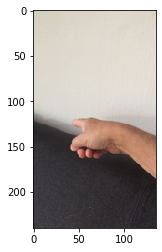

Desired Output (target picture):


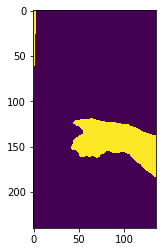

Actual Output:


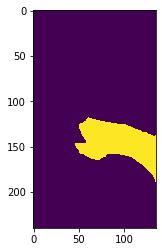

In [20]:
index = 10
test_input = torch.Tensor([X_train_norm[index]]) # wraps X_norm[number] in a list because that's what the model expects
print(test_input.shape)

if use_cuda and torch.cuda.is_available():
      test_input = test_input.cuda()

output_test = model.forward(test_input)
print(output_test.shape)

if use_cuda and torch.cuda.is_available():
      output_test = output_test.cpu() # Copies Tensor to CPU so it can be converted to NumPy so it can be printed


plt.imshow(np.reshape(X_train[index], [X_train[index].shape[1], X_train[index].shape[2], X_train[index].shape[0]]).astype('uint8'))
print("Input Picture:")
plt.show()
plt.imshow(y_train[index])
print("Desired Output (target picture):")
plt.show()
plt.imshow(torch.argmax(output_test, dim = 1)[0])
print("Actual Output:")
plt.show()

### Validation Data

torch.Size([1, 2, 240, 135])
torch.Size([240, 135])
torch.Size([1, 240, 135])
Input Picture:


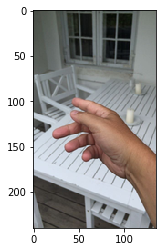

Actual Output:


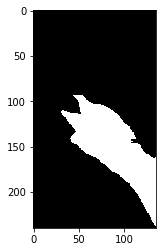

torch.Size([1, 2, 240, 135])
torch.Size([240, 135])
torch.Size([1, 240, 135])
Input Picture:


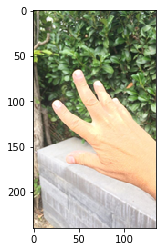

Actual Output:


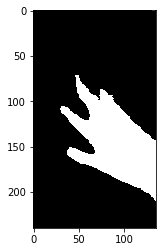

In [19]:
for index in range(0,2):
    test_input = torch.Tensor([X_test_norm[index]]) # wraps X_norm[number] in a list because that's what the model expects

    if use_cuda and torch.cuda.is_available():
          test_input = test_input.cuda()

    output_test = model.forward(test_input)
    print(output_test.shape)
    print(torch.Tensor(y_test[index]).shape)
    print(torch.argmax(output_test, dim = 1).shape)

    if use_cuda and torch.cuda.is_available():
          output_test = output_test.cpu() # Copies Tensor to CPU so it can be converted to NumPy so it can be printed


    plt.imshow(np.reshape(X_test[index], [X_test[index].shape[1], X_test[index].shape[2], X_test[index].shape[0]]).astype('uint8'))
    print("Input Picture:")
    plt.show()
    #plt.imshow(y_test[index])
    #print("Desired Output (target picture):")
    #plt.show()
    plt.imshow(torch.argmax(output_test, dim = 1)[0], cmap='gray')
    print("Actual Output:")
    plt.show()

## Train vs Test Loss

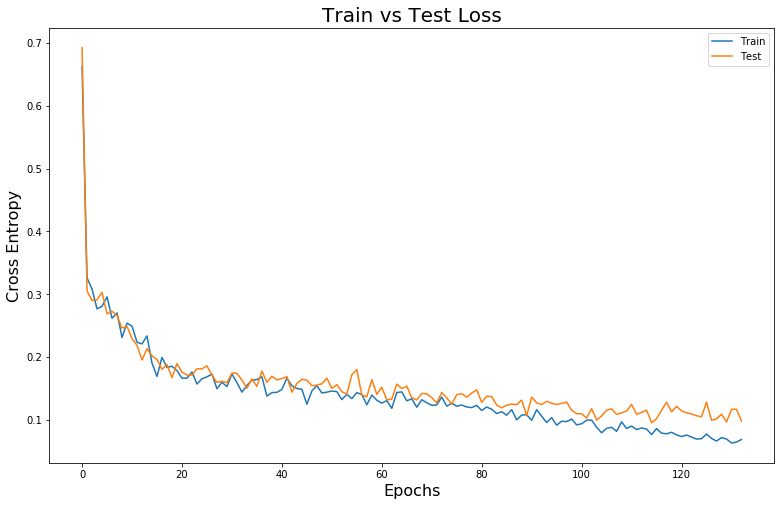

In [13]:
plt.figure(figsize=(13,8))
plt.plot(range(len(traincosts)), traincosts)
plt.plot(range(len(testcosts)), testcosts)
#plt.yscale('log')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Cross Entropy', fontsize=16)
plt.title("Train vs Test Loss", fontsize=20)
plt.legend(["Train", "Test"])
plt.show()

### F1 Score on Validation Data

In [ ]:
for index in range(10):
    test_input = torch.Tensor([X_test_norm[index]]) # wraps X_norm[number] in a list because that's what the model expects

    if use_cuda and torch.cuda.is_available():
          test_input = test_input.cuda()

    output_test = model.forward(test_input)

    if use_cuda and torch.cuda.is_available():
          output_test = output_test.cpu() # Copies Tensor to CPU so it can be converted to NumPy so it can be printed


    #plt.imshow(np.reshape(X_test[index], [X_test[index].shape[1], X_test[index].shape[2], X_test[index].shape[0]]).astype('uint8'))
    #print("Input Picture:")
    #plt.show()
    plt.imshow(y_test[index], cmap='gray')
    print("Desired Output (target picture):")
    plt.show()
    plt.imshow(torch.argmax(output_test, dim = 1)[0], cmap='gray')
    print("Actual Output:")
    plt.show()
    print("F1 score:")
    print(F1_score(y_test[index], output_test))
    print('--------------------------------------------------------')

In [18]:
scores = []
for index in range(len(X_test_norm)):
    test_input = torch.Tensor([X_test_norm[index]]) # wraps X_norm[number] in a list because that's what the model expects

    if use_cuda and torch.cuda.is_available():
          test_input = test_input.cuda()

    output_test = model.forward(test_input)

    if use_cuda and torch.cuda.is_available():
          output_test = output_test.cpu() # Copies Tensor to CPU so it can be converted to NumPy so it can be printed            
            
    f1 = F1_score(y_test[index], output_test)
    scores.append(f1)
    
print("Average F1 score on Validation set:", np.mean(scores))

Average F1 score on Validation set: 0.915314349225117


In [16]:
def F1_score(Y_test, Y_output, verbose=False):
    
    if verbose:
        plt.imshow(Y_test, cmap='gray')
        plt.show()

    Y_output = Y_output.detach().numpy()
    Y_output = np.argmax(Y_output, axis=1)[0]
    
    if verbose:
        plt.imshow(Y_output, cmap='gray')
        plt.show()
        print(Y_test.shape)
        print(Y_output.shape)
        print(Y_test.reshape(-1).shape)
        print(Y_output.reshape(-1).shape)

    F1_score = f1_score(Y_test.reshape(-1), Y_output.reshape(-1), average='macro')


    return F1_score